# Mini project 10.3.3

# Basic Text Classification with Naive Bayes

## Example:  Set up

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Skip this defaul style 
# sns.set_style("whitegrid")
# sns.set_context("poster")

# Use this instead
plt.style.use('ggplot')

## Example:  Load data

In [2]:
critics = pd.read_csv('./critics.csv')

## Example:  Clean data

In [3]:
# Drop rows with missing quotes
critics = critics[~critics.quote.isnull()]

## Example:  Explore data

In [4]:
critics.head(3)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story


In [5]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


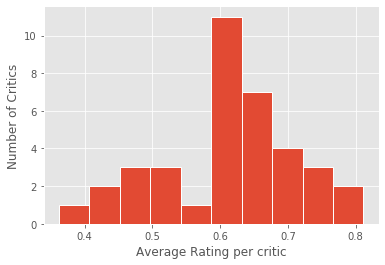

In [6]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

In [7]:
# Bit more exploration
df['fresh'].unique()

array([ True, False])

### Exercise I:  Interpret the histogram

**Question:**  Tell a story about the average ratings per critic. What shape does the distribution look like?  What is interesting about the distribution?  What might explain these interesting things?

** Answer** 

My read of average ratings of critics who write lots of reviews says:

* There are a few critics who like just about everything
* There are fewer critics who don;t like most everything
* Most critics like more than 60% of their movies or more
* The most common critic likes about 60% of their movies
* Average reviews aren't a normal distribution.  It's weighted toward 'fresh.'
* There's a big drop of critics who like about 50% of what they see (as compared to those who like 60%)

## Prep data for ML

### Example:  Build a text vector

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [9]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

In [10]:
print(y)

[1 1 1 ... 1 1 1]


## Model with Naive Bayes

## Exercise II:  Build a simple Naive Bayes classifier

In [11]:
# Import modules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Instantiate the model
nb_simple = MultinomialNB()

# Fit the model
nb_simple.fit(X_train, y_train)

# Score the model
nb_simple_score_train = nb_simple.score(X_train, y_train)
nb_simple_score_test = nb_simple.score(X_test, y_test)

# Print results
print('The training score is {:.3f}'.format(nb_simple_score_train))
print('The test score is {:.3f}'.format(nb_simple_score_test))
print('The difference is {:.3f}'.format((nb_simple_score_train - nb_simple_score_test)))
print('The difference as percent is {:.3f}'.format((nb_simple_score_train - nb_simple_score_test)/ nb_simple_score_train))


The training score is 0.921
The test score is 0.778
The difference is 0.143
The difference as percent is 0.155


The model is overfit:

* The test set underperforms the training set
* By about 15%

## Tune model

### Understand the distribution of key features via cdf

**Construct the cumulative distribution of document frequencies (df).**

* The  𝑥 -axis is a document count  𝑥𝑖  and the  𝑦 -axis is the percentage of words that appear less than  𝑥𝑖  times. 
* For example, at  𝑥=5 , plot a point representing the percentage or number of words that appear in 5 or fewer documents.

In [12]:
# Import a scipy package
import scipy.sparse

In [13]:
# Turn scipy sparse matrix into a pandas data frame
df_full = pd.DataFrame.sparse.from_spmatrix(X)

In [14]:
# Sort words from docs
no_docs = len(df_full)
print('The number of docs is {}'.format(no_docs))
no_words = len(df_full.columns)
print('The number of words is {}'.format(no_words))

The number of docs is 15561
The number of words is 22417


In [15]:
# Calc number of words appearing in number of documents
doc_ct_by_word_id = df_full.sum(axis=0)
doc_ct_by_word_id.sort_values(inplace=True)
doc_ct_by_word_ct = pd.DataFrame(doc_ct_by_word_id.value_counts(), columns = ['appearances'])
doc_ct_by_word_ct.index.name = 'no_words'
doc_ct_by_word_ct.sort_index(inplace=True)
doc_ct_by_word_ct['appear_pct'] = doc_ct_by_word_ct['appearances']/doc_ct_by_word_ct['appearances'].sum()
doc_ct_by_word_ct['appear_pct_cuml'] = doc_ct_by_word_ct['appear_pct'].cumsum()

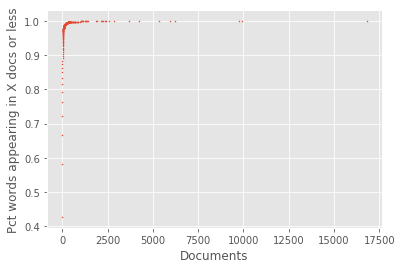

In [16]:
# Visualie overall cdf
_ = plt.scatter(doc_ct_by_word_ct.index, doc_ct_by_word_ct['appear_pct_cuml'], s=1)
_ = plt.xlabel('Documents')
_ = plt.ylabel('Pct words appearing in X docs or less')

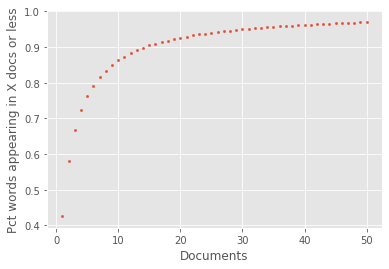

In [17]:
# Visualize cdf - first 50 values
doc_ct_by_word_ct_slice = doc_ct_by_word_ct.iloc[0:50]
plt.scatter(doc_ct_by_word_ct_slice.index, doc_ct_by_word_ct_slice['appear_pct_cuml'], s=5)
_ = plt.xlabel('Documents')
_ = plt.ylabel('Pct words appearing in X docs or less')

### Look for key values for min_df

I want a 'Goldilocks' zone:

* Eliminate words that are two common.  Aka, the large mass of words that appear in 'most' don't have much info value.
* Eliminate words that are too rare.  Aka, those rare words--while having lots of info--aren't worth the computation costs.

In [18]:
# Check out a list of values
doc_ct_by_word_ct['appear_pct_cuml'].iloc[0:100]

# Look at the percent eliminated by dropping the most common X words
possible_min_df = 15
print('If you drop the first {} words, you eliminate {:.1f} percent of the docs'.format(possible_min_df, doc_ct_by_word_ct['appear_pct_cuml'].loc[possible_min_df]*100))
print()
print()

# Look at the words you can drop while still achieving X percent coverage
possible_per_cover = 99.87
lower = doc_ct_by_word_ct[doc_ct_by_word_ct['appear_pct_cuml'] < possible_per_cover/100]
print(lower.tail(1))
upper = doc_ct_by_word_ct[doc_ct_by_word_ct['appear_pct_cuml'] > possible_per_cover/100]
print(upper.head(1))
print()
print()

# Assume a value for max
possible_max_df = 1018
print('If you keep only {} words, you lose only {:.3f} percent of the docs'.format(possible_max_df, ((100-doc_ct_by_word_ct['appear_pct_cuml'].loc[possible_max_df]*100))))

If you drop the first 15 words, you eliminate 90.5 percent of the docs


          appearances  appear_pct  appear_pct_cuml
no_words                                          
1018                1    0.000045         0.998662
          appearances  appear_pct  appear_pct_cuml
no_words                                          
1024                1    0.000045         0.998706


If you keep only 1018 words, you lose only 0.134 percent of the docs


## Example: Define function to manually score various folds

In [19]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [20]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

In [21]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

## Exercise IV:  Continue to tune

**Answers**

* We're using `log_likelihood` as the score becuase:  As per StackOverflow:  Naive Bayes classifiers typically work in logspace themselves for reasons of stability and speed, so first computing exp(logP) only to get logP back later is wasteful.

* Alpha smooths the effects of rare words.  With a very high value of alpha, you would be very insensitive to the impact of rare words

**Exercise**

* Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.

In [22]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 10

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    clf = MultinomialNB(alpha=alpha)
    cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)
    if cvscore > maxscore:
        maxscore = cvscore
        best_alpha = alpha

In [23]:
print("alpha: {}".format(best_alpha))

alpha: 5


## Exercise V:  Test the best model

In [24]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data: {:2f}".format(test_accuracy))

Accuracy on training data: 0.818591
Accuracy on test data: 0.714745


**Assess overfit**

* We are no longer overfitting as training score is above test score.

In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1812 2446]
 [ 661 5973]]


However, we've got a good number of errors, especially with:

* Predicted fresh but actually non-fresh at 2415
* Not predicted fresh but actually fresh at 661

## Do more feature selection

### Example:  List the strongly predictive features

In [26]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         intelligent 0.88
         masterpiece 0.85
              moving 0.85
        entertaining 0.85
               gives 0.85
             perfect 0.83
           hitchcock 0.83
               great 0.83
              beauty 0.83
                 art 0.82
Bad words	     P(fresh | word)
             unfunny 0.30
        unsatisfying 0.30
               lacks 0.30
           pointless 0.29
       unfortunately 0.27
                lame 0.27
                dull 0.26
             problem 0.25
               bland 0.25
               fails 0.25


**Question:**  Why does this method work? What does the probability for each row in the identity matrix represent?

**Answer:** This method works because it is calculating the probability of a fresh review for a given word.  Then, it is looking at the most probable and least probably words.

### Example:  Look at prediction errors

We can see mis-predictions as well.

In [27]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

The Disney organization is worst when it makes "family entertainment" and best when it sticks to pure, simple, charming fantasy.

There is scarcely a moment in the movie when the story works as fiction; I was always aware of the casting, of the mood-setting devices, of the stylistic borrowings from Hitchcock.

Alfred Hitchcock's 1966 spy thriller has one of the lowest reputations of his late works. Coming after a masterpiece like Marnie, it almost had to be a disappointment. But Hitchcock was incapable of making an uninteresting film.

Just as the characters' motivations are mostly crude rather than complex, and the view of class politics superficial and romantic rather than acute or intelligent, so is 

## Exercise VII:  Apply model to individual data points

### Predict label from new text

**Question**

* Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
* Is the result what you'd expect? Why (not)?

In [28]:
clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
txt = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
print (clf.predict(txt))

[1]


This review is predicted as fresh (aka, 1) but it's not.  And this error makes sense.

* Many of the words associated with the sentence are highly likely to be fresh
* For example, remarkable, touching, or superb 
* But there's a single word 'not' which flips the meaning
* And this method doesn't take such linguistic concepts into account

## Optional exercises:  Build more models

There are several additional things we could try. Try some of these as exercises:

* Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
* Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
* Try adding supplemental features -- information about genre, director, cast, etc.
* Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
* Use TF-IDF weighting instead of word counts.

#### Build TF-IDF model to account for term importance (example)

In [29]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)